# Singular value decomposition (SVD)

The singular value decompostion of a real-valued $m \times n$ matrix $\boldsymbol{A}$ is:

$$
\boldsymbol{A} = \boldsymbol{U} \boldsymbol{\Sigma} \boldsymbol{V}^{T}
$$

where

- $\boldsymbol{U}$ is an $m \times m$ orthogonal matrix;
- $\boldsymbol{\Sigma}$ is an $m \times n$ diagonal matrix with diagonal entries $\sigma_{1} \ge  \sigma_{2} \ge \ldots \ge \sigma_{p} \ge 0$, where $p = \min(m, n)$; and
- $\boldsymbol{U}$ is an $n \times n$ orthogonal matrix.

We will use NumPy to compute the SVD and Matplotlib to visualise results, so we first import some modules:

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

**Note:** If you run this notebook yourself it can take sometime because it computes number of moderate size SVD problems.

## Low rank approximations

Recall that we can represent a matrix as a sum of rank-1 matrices:

$$
\boldsymbol{A} = \sum_{i} \sigma_{i} \boldsymbol{u}_{i} \boldsymbol{v}^{T}_{i}
$$

where $\sigma_{i}$ is the $i$th singular value and $\boldsymbol{u}_{i}$ and $\boldsymbol{v}_{i}$ are the $i$th columns vectors of $\boldsymbol{U}$ and $\boldsymbol{V}$, respectively from the SVD. Clearly, for any $\sigma_{i} = 0$ we can avoid storing the data that makes no contribution. If $\sigma_{i}$ is small, then the contribution of $\boldsymbol{u}_{i} \boldsymbol{v}^{T}_{i}$ is small and we discard it and introduce only a small 'error' to the matrix. We will use low rank approximations in a number of examples in this notebook.

## Data compression

We start with a $100 \times 200$ matrix that has entries equal to one or zero. We create a matrix with all entries set to zero, and we then set some entries equal to one in the pattern of rectangle.

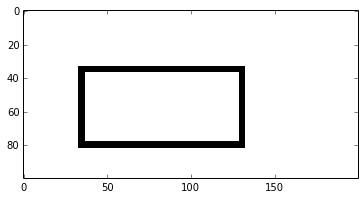

In [2]:
A = np.ones((100, 200))
A[33:33 + 4, 33:133] = 0.0
A[78:78 + 4, 33:133] = 0.0
A[33:78+4, 33:33+4] = 0.0
A[33:78+4, 129:129+4] = 0.0
plt.imshow(A, cmap='gray', interpolation='none');  

Performing the SVD and counting the number of singular values that are greater than $10^{-9}$:

In [3]:
U, s, V = np.linalg.svd(A, full_matrices=False)
print("Number of singular values greater than 1.0e-9: {}".format((s > 1.0e-9).sum()))

Number of singular values greater than 1.0e-9: 3


With only three nonzero singular values, we could reconstruct the matrix with very little data - just three singular values and six vectors.

### Removing noise

We consider the same matrix problem again, this time with some back ground noise in the white regions.

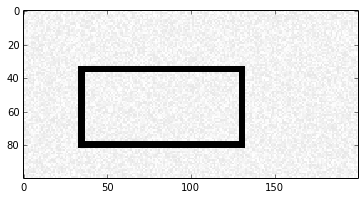

In [4]:
A = np.ones((100, 200))
A = A - 1.0e-1*np.random.rand(100, 200)
A[33:33 + 4, 33:133] = 0.0
A[78:78 + 4, 33:133] = 0.0
A[33:78+4, 33:33+4] = 0.0
A[33:78+4, 129:129+4] = 0.0
plt.imshow(A, cmap='gray', interpolation='none');  

The effect of the noise is clear in the image.

We can try to eliminate much of the background noise via a low-rank approximation of the noisy image that discards information associated with small singular values of the matrix.

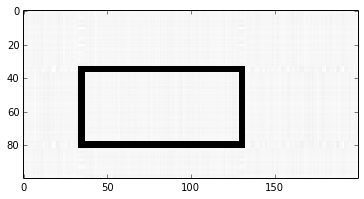

In [5]:
# Compute SVD of nois matrix
U, s, V = np.linalg.svd(A, full_matrices=False)

# Set any singular values less than 1.0 equation zero
s[s < 1.0] = 0.0

# Reconstruct low rank approximation and display
A_denoised = np.dot(U, np.dot(np.diag(s), V))
plt.imshow(A_denoised, cmap='gray', interpolation='none');  

We can see that much of the noise in the image has been eliminated.

## Image compression

### Gray scale image

We load a colour PNG file. It uses three colour channels (red/green/blue), with at each pixel an 8-bit unsigned integer (in the range $[0, 255]$, but sometimes represented as a float) for each colour for the colour intensity. This is know as 24-bit colour - three channels times 8 bit.

We load the image as three matrices (red, green, blue), each with dimension equal to the number pixels in each direction: 

Image array shape: (2046, 1446, 3)


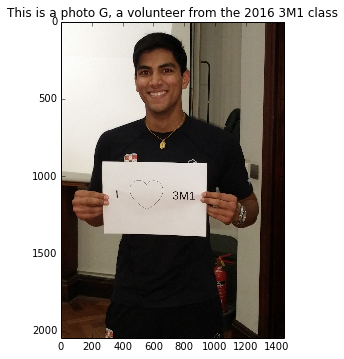

In [6]:
img_colour = plt.imread('photo/20160114_151455.png')
print("Image array shape: {}".format(img_colour.shape))

plt.figure(figsize=(4, 4*1.44))
plt.title('This is a photo G, a volunteer from the 2016 3M1 class')
plt.imshow(img_colour);

This image is has $2046 \times 1446$ pixels.

We could work with the colour image, but it is simpler to work with a gray scale image because then we have only one value for the colour intensity at each pixel rather than three (red/green/blue). We use a trick to create a gray scale image using Matplotlib: 

Image array shape: (2046, 1446)


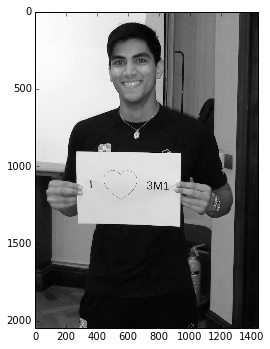

In [7]:
img = matplotlib.colors.rgb_to_hsv(img_colour)[:,:,2]
plt.figure(figsize=(4, 4*1.44))
plt.imshow(img, cmap='gray');      
print("Image array shape: {}".format(img.shape))

We now have a regular matrix, with each entry corresponding to a pixel in the image. We can inspect part of it. For the first four rows and three columns (top left corner of the image):

In [8]:
img[:4, :3]     

array([[ 0.98039216,  0.98823529,  0.98823529],
       [ 0.98823529,  0.98823529,  0.98823529],
       [ 0.99215686,  0.98823529,  0.98823529],
       [ 0.98823529,  0.98431373,  0.98823529]])

Now, maybe we can discard information associated with small singular values without perceiving any visual change in the image. To explore this, we compute the SVD of the gray scale image:

In [9]:
U, s, V = np.linalg.svd(img, full_matrices=False)

The argument `full_matrices=False` tells NumPy to not store all the redundant zero terms in the $\boldsymbol{\Sigma}$ array. This is the normal approach in practice, but not in most text books.

We now print the largest and smallest singular values, and plot all the singular values $\sigma_{i}$ on a log-scale:

Number of singular values: 1446
Max, min singular values: 820.526329211, 0.0257998020198


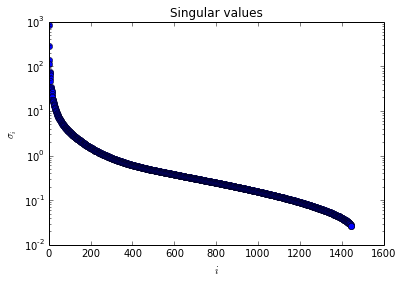

In [10]:
print("Number of singular values: {}".format(len(s)))
print("Max, min singular values: {}, {}".format(s[0], s[-1]))

plt.xlabel('$i$')
plt.ylabel('$\sigma_i$')
plt.title('Singular values')
plt.yscale('log')
plt.plot(s, 'bo');

We can now try compressing the image. We first try retaining using only the largest 25% of values: 

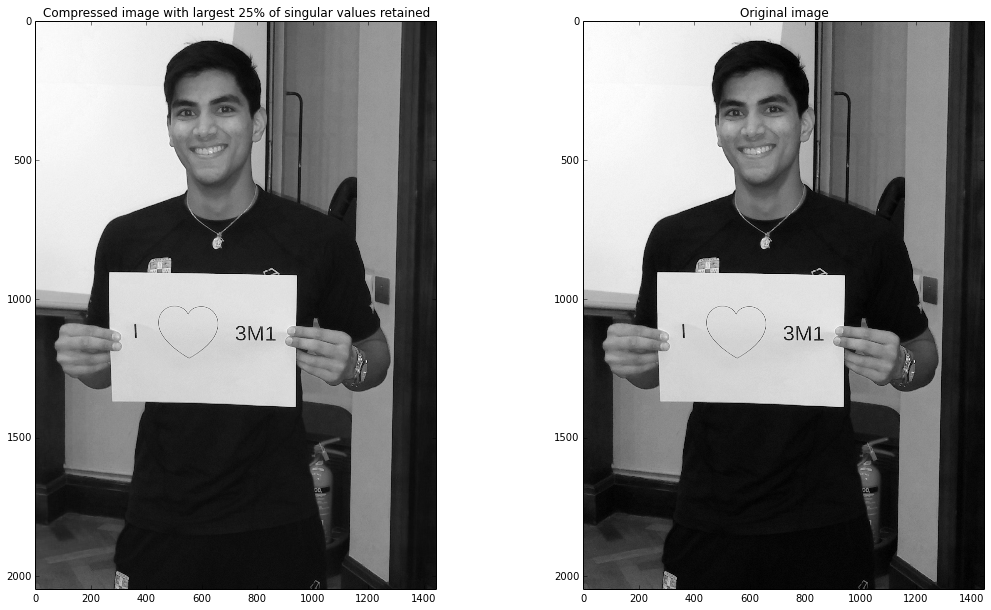

In [11]:
# Copy singular values
s_compressed = s.copy()

# Compute num_sigma/4 (25%) and zero values 
n = int(0.25*len(s_compressed)) 
s_compressed[n:] = 0.0

# Reconstruct image
compressed = np.dot(U, np.dot(np.diag(s_compressed), V))

# Plot compressed and original image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 18/1.77));
axes[0].set_title('Compressed image with largest 25% of singular values retained')
axes[0].imshow(compressed, cmap='gray');
axes[1].set_title('Original image')
axes[1].imshow(img, cmap='gray');           

We have discarded 3/4 of the singular values, but can  barely perceive a difference in the image.

To explore other levels of compression, we write a function that takes the fraction of singular values we wish to retain:

In [12]:
def compress_image(U, s, V, f):
    "Compress image where 0 < f <= 1 is the fraction on singular values to retain"

    s_compressed = s.copy()
    n = int(f*len(s_compressed))
    s_compressed[n:] = 0.0
    return np.dot(U, np.dot(np.diag(s_compressed), V))

Let's try retaining just 5% of the singular values:

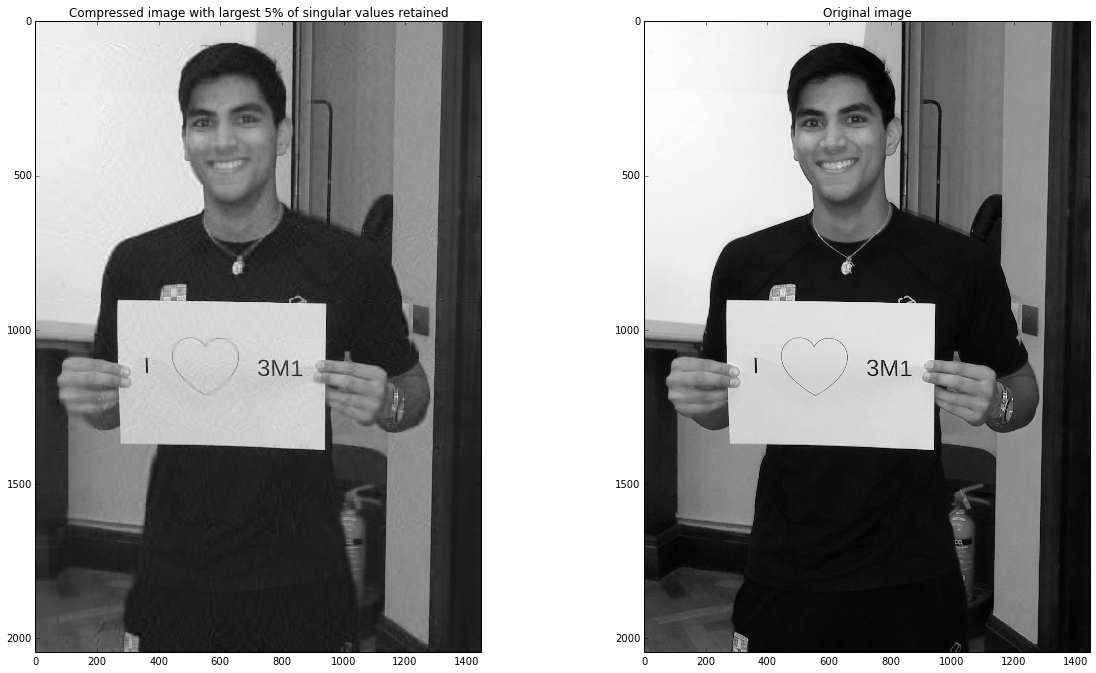

In [13]:
# Compress image/matrix
compressed = compress_image(U, s, V, 0.05)

# Plot compressed and original image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/1.77))
axes[0].set_title('Compressed image with largest 5% of singular values retained')
axes[0].imshow(compressed, cmap='gray');
axes[1].set_title('Original image')
axes[1].imshow(img, cmap='gray');

Even with only 5% if the singular values retains, it is hard to perceive a difference between the images. Next we try keeping only 2%: 

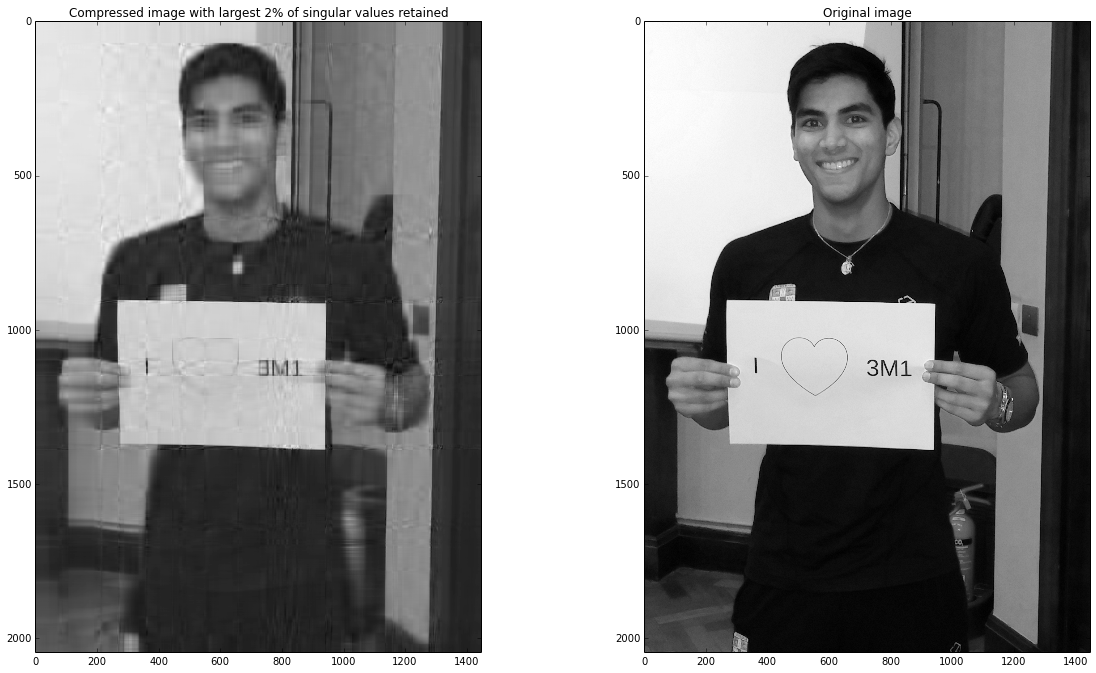

In [14]:
# Compress image/matrix
compressed = compress_image(U, s, V, 0.02)

# Plot compressed and original image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/1.77))
axes[0].set_title('Compressed image with largest 2% of singular values retained')
axes[0].imshow(compressed, cmap='gray');
axes[1].set_title('Original image')
axes[1].imshow(img, cmap='gray');

We now see some image clear degradation, but the image is sill recognisable. We'll try one more case where we retain only 0.5% of the singular values. 

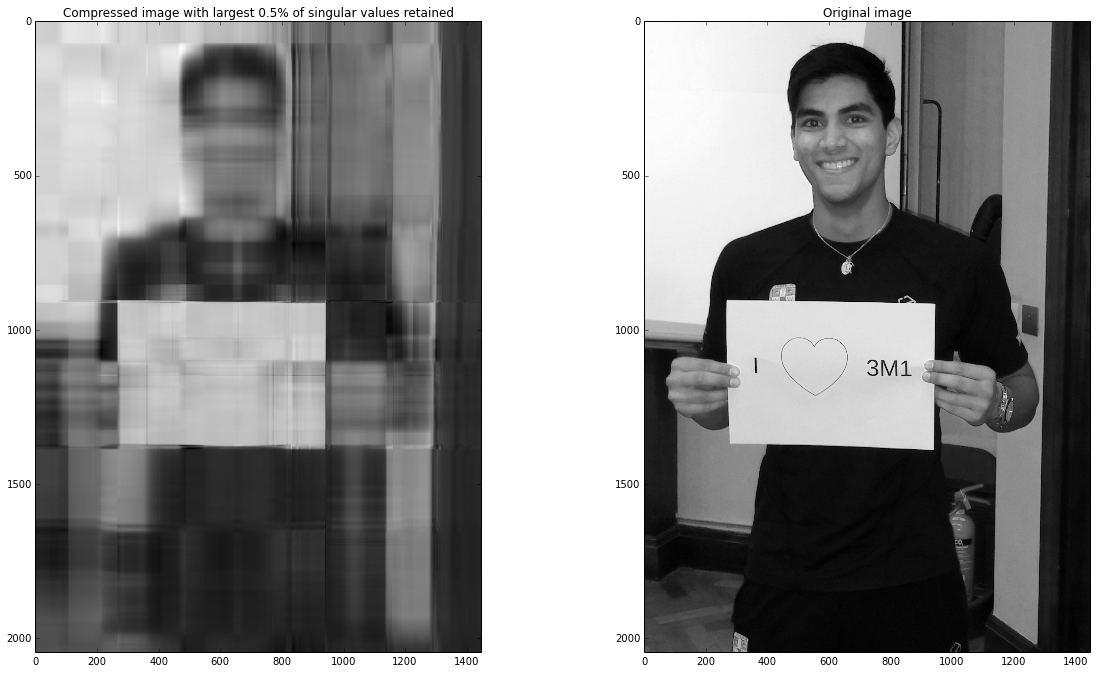

In [15]:
# Compress image/matrix
compressed = compress_image(U, s, V, 0.005)

# Plot compressed and original image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/1.77))
axes[0].set_title('Compressed image with largest 0.5% of singular values retained')
axes[0].imshow(compressed, cmap='gray');
axes[1].set_title('Original image')
axes[1].imshow(img, cmap='gray');

The image quality is now quite poor.

### Colour image

We'll now try compressing a colour image. To do this, it is best to transform the colours from R/G/B into separate brightness and colour components (e.g. Y/Cb/Cr)

Image array shape: (1947, 2451, 3)


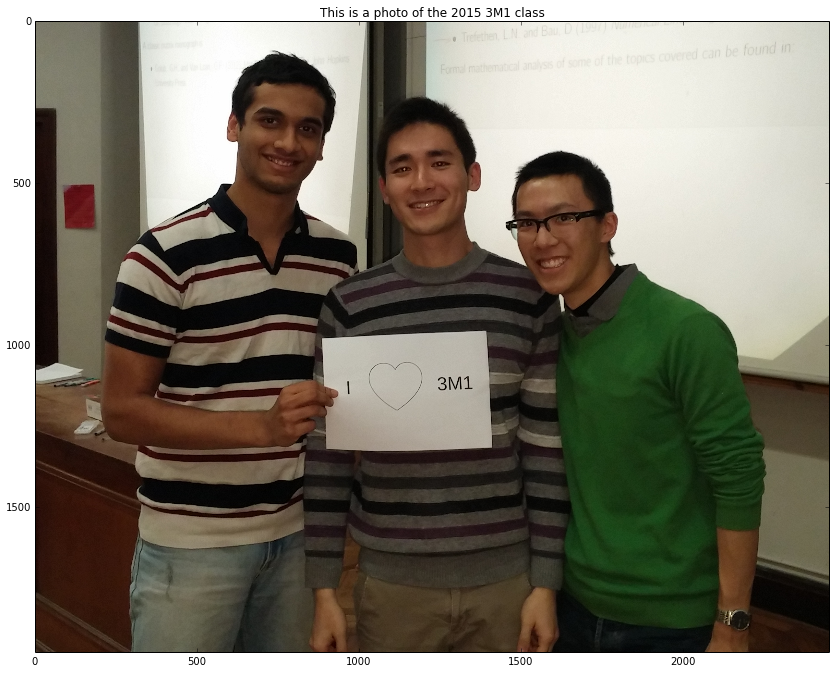

In [96]:
from PIL import Image
img_colour = plt.imread('photo/20160114_151553.png')
img_colour_ycbcr = np.array(Image.open('photo/20160114_151553.png').convert("YCbCr"))
print("Image array shape: {}".format(img_colour.shape))

plt.figure(figsize=(20,20/1.77))
plt.title('This is a photo of the 2015 3M1 class')
plt.imshow(img_colour);

We can extract the luminance and chroma components to have a look:

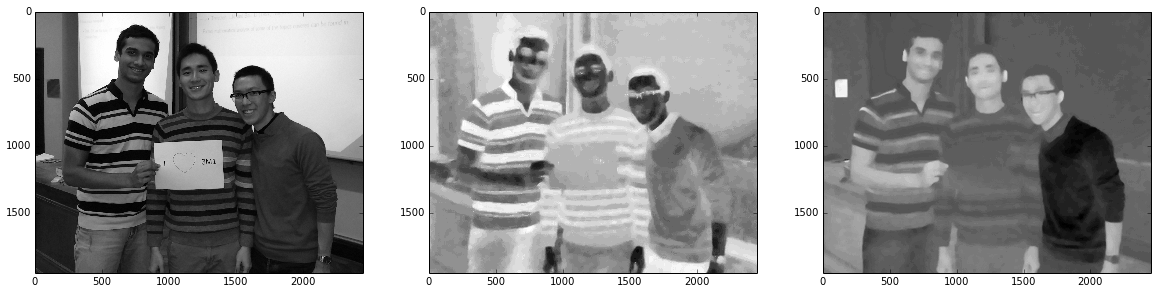

In [97]:
# Display Luminance(Y), Blue Chroma(Cb) and Red Chroma(Cr) channels
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20/1.77))

Y = img_colour_ycbcr[:,:,0]
axes[0].imshow(Y, cmap='gray');

Cb = img_colour_ycbcr[:,:,1]
axes[1].imshow(Cb, cmap='gray');

Cr = img_colour_ycbcr[:,:,2]
axes[2].imshow(Cr, cmap='gray');

We now compute an SVD for the matrix of each component:

In [98]:
# Compute SVD for each colour
U, s, V = [0]*3, [0]*3, [0]*3
for i in range(3):
    U[i], s[i], V[i] = np.linalg.svd(img_colour_ycbcr[:, :, i], full_matrices=False)

Compressing the matrix for each component separately and then reconstruct the three-dimensional array:

In [111]:
# Compress each component separately
compressed = [compress_image(U[0], s[0], V[0], 0.2),
              compress_image(U[1], s[1], V[1], 0.005),
              compress_image(U[2], s[2], V[2], 0.005)]
# Reconstruct 3D RGB array
compressed = np.dstack(compressed)

The colour infomation can be compressed quite heavily. Comparing the compressed and original images side-by-side:

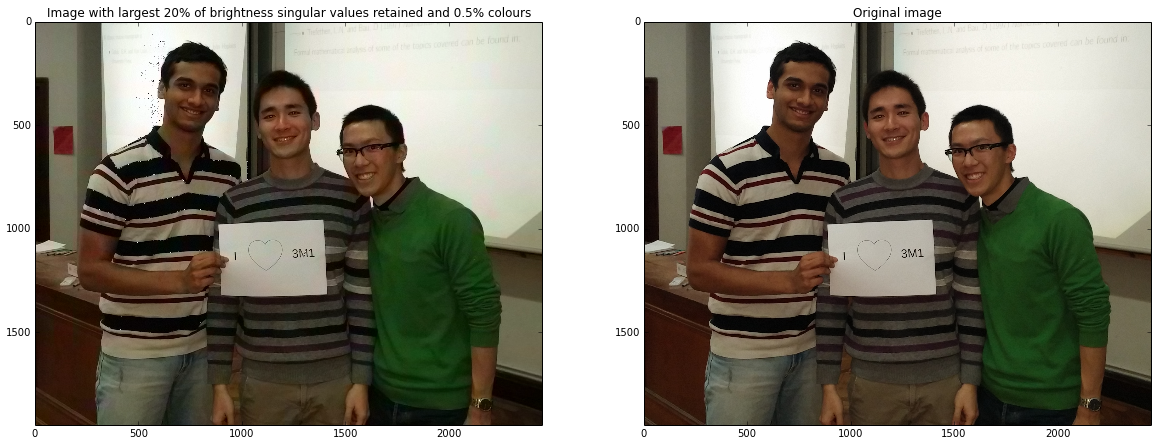

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/1.77))
axes[0].set_title('Image with largest 20% of brightness singular values retained and 0.5% colours')
im = Image.fromarray(np.uint8(compressed), mode="YCbCr")
axes[0].imshow(im)
axes[1].set_title('Original image')
axes[1].imshow(img_colour)

There are some artefacts due to under/over-exposure.

### Interactive compression

We'll now create an interactive image with a slider to control the compression level.

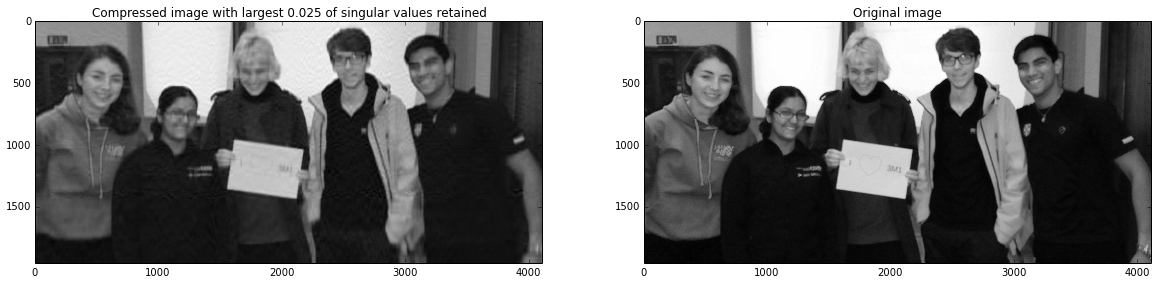

In [82]:
from ipywidgets import widgets
from ipywidgets import interact

# Read image
img_colour = plt.imread('photo/20160114_151533.png')

# Convert to gray scale
img = matplotlib.colors.rgb_to_hsv(img_colour)[:,:,2]

# Compute SVD
U, s, V = np.linalg.svd(img, full_matrices=False)

@interact(ratio=(0.005, 0.2, 0.02))
def plot_image(ratio=0.01):

    # Compress image 
    A = compress_image(U, s, V, ratio)

    # Plot images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/1.77))
    axes[0].set_title('Compressed image with largest {} of singular values retained'.format(ratio))
    axes[0].imshow(A, cmap='gray');

    axes[1].set_title('Original image')
    axes[1].imshow(img, cmap='gray');

## Effective rank

Determining the rank of a matrix is not a binary question in the context of floating point arithmetic or measurement errors. The SVD can be used to determine the 'effective rank' of a matrix. 

Consider the matrix:

In [22]:
A = np.array([[1, 1, 1], [2, 2, 2], [1, 0 ,1]])
print(A)

[[1 1 1]
 [2 2 2]
 [1 0 1]]


Clearly the first two rows are linearly dependent and the rank of this matrix is 2. We can verify this using NumPy:

In [23]:
print("Rank of A is: {}".format(np.linalg.matrix_rank(A)))

Rank of A is: 2


We now add some noise in the range $(0, 10^{-6})$ to the matrix entries:

In [24]:
np.random.seed(10)
A = A + 1.0e-6*np.random.rand(A.shape[0], A.shape[1])

We now test the rank:

In [25]:
print("Rank of A (with noise) is: {}".format(np.linalg.matrix_rank(A)))

Rank of A (with noise) is: 3


The problem is that we have a 'data set' that is linearly dependent, but this is being masked by very small measurement noise. 

Computing the SVD of the matrix with noise and printing the singular values:

In [26]:
U, s, V = np.linalg.svd(A)
print("The singular values of A (with noise) are: {}".format(s))

The singular values of A (with noise) are: [  4.04844133e+00   7.81109622e-01   7.86339403e-08]


If we define the effective rank as the number of singular values that are greater than the noise level, the effective rank of $\boldsymbol{A}$ is 2.

## Rank deficient least-squares problems

For least squares problem, we have seen before that we solve

$$
\boldsymbol{A}^{T} \boldsymbol{A} \hat{\boldsymbol{x}} = \boldsymbol{A}^{T} \boldsymbol{b}
$$

or

$$
\begin{align}
\hat{\boldsymbol{x}} &= (\boldsymbol{A}^{T} \boldsymbol{A})^{-1} \boldsymbol{A}^{T} \boldsymbol{b}
\\
&= \boldsymbol{A}^{+}\boldsymbol{b}
\end{align}
$$

Everything is fine as long as $\boldsymbol{A}$ is full rank. The problem is that we might have data that leads to $\boldsymbol{A}$ not being full rank. For example, if we try to fit a polynomial in $x$ and $y$, but the data lies on a line. 

We have covered in the lectures how to handle least-squares problems that are rank deficient. Here we present an example.

### Example: fitting points in a two-dimensional space

Say we are given four data points that depend on $x$ and $y$, and we are asked to fit a polynomial of the form

$$
f(x, y) = c_{00} + c_{10}x + c_{01}y + c_{11}xy
$$

to the data points. Normally, we would expect to be able to fit the above polynomial to four data points by interpolation, i.e. solving $\boldsymbol{A} \boldsymbol{c} = \boldsymbol{f}$ where
$\boldsymbol{A}$ a square Vandermonde matrix. However, if the points happened to lie on a line, then $\boldsymbol{A}$ will be singular. If the points happen to almost lie on a line, then $\boldsymbol{A}$ will be close to singular. 

A possibility is to exclude zero or small singular values from the process, thereby finding a least-squares fit with minimal $\|\boldsymbol{c}\|_{2}$. We test this for the data set 
$f_{1}(1, 0) = 1$,
$f_{2}(2, 0) = 2$,
$f_{3}(3, 0) = 3$,
$f_{4}(4, 0) = 4$.
The data lies on the line $y = 0$, and is in fact is linear in $x$.

We create arrays to hold this data:

In [27]:
x, y, f = np.zeros(4), np.zeros(4), np.zeros(4)
x[0], y[0], f[0] = 1.0, 0.0, 3.0
x[1], y[1], f[1] = 2.0, 0.0, 5.0
x[2], y[2], f[2] = 3.0, 0.0, 7.0
x[3], y[3], f[3] = 4.0, 0.0, 9.0

To find the polynomial coefficients we want to solve
$$
\begin{bmatrix}
1 & x_{1} & y_{1} & x_{1}y_{1}  \\  
1 & x_{2} & y_{2} & x_{2}y_{2}  \\  
1 & x_{3} & y_{3} & x_{3}y_{3}  \\  
1 & x_{4} & y_{4} & x_{4}y_{4}  \\  
\end{bmatrix}
\begin{bmatrix}
c_{00} \\ c_{10} \\ c_{01} \\ c_{11}  
\end{bmatrix}
=
\begin{bmatrix}
f_{1} \\ f_{2} \\ f_{3} \\ f_{4}  
\end{bmatrix}
$$

where the matrix is the Vandermonde matrix. We can use a NumPy function to create the Vandermonde matrix:

In [28]:
A = np.polynomial.polynomial.polyvander2d(y, x, [1, 1])
print(A)

[[ 1.  1.  0.  0.]
 [ 1.  2.  0.  0.]
 [ 1.  3.  0.  0.]
 [ 1.  4.  0.  0.]]


It is clear by inspection that $\boldsymbol{A}$ is not full rank, and is rank 2.

Computing the SVD of $\boldsymbol{A}$ and printing the singular values:

In [29]:
U, s, V = np.linalg.svd(A)
print(s)

[ 5.77937881  0.77380911  0.          0.        ]


We can see that two of the singular values are zero. To find a least-squares fit to the data with minimal $\| \boldsymbol{c}\|_{2}$ we compute

$$
\hat{\boldsymbol{c}} = \boldsymbol{V}_{1} \boldsymbol{\Sigma}^{+} 
\boldsymbol{U}_{1}^{T}\boldsymbol{b}
$$

Creating $\boldsymbol{V}_{1}$,  $\boldsymbol{\Sigma}^{+}$ and $\boldsymbol{U}_{1}$ (recall that the NumPy SVD returns $\boldsymbol{V}^{T}$ rather than  $\boldsymbol{V}$): 

In [30]:
# Create view of U with last two columns removed 
U1 = U[:, :2]

# Create view of V with last two columns removed 
V1 = V[:2,:]

# Create Sigma^{+}
S1 = np.diag(1.0/s[:-2])

Computing the least-squares solution from $\hat{\boldsymbol{c}} = \boldsymbol{V}_{1} \boldsymbol{\Sigma}^{+} \boldsymbol{U}_{1}^{T}\boldsymbol{b}$:

In [31]:
c = np.transpose(V1).dot(S1.dot(U1.T).dot(f))
print(c)

[ 1.  2.  0.  0.]


The solution is $f(x, y) = 1 + 2x$, which in this case in fact interpolates the data points.

We now try adding some noise to the sample positions and the measured values. The Vandermonde matrix is no longer singular so we can solve $\boldsymbol{A} \boldsymbol{c} = \boldsymbol{f}$ to get the polynomial coefficients:

In [32]:
np.random.seed(20)
xn = x + 1.0e-3*(1.0 - np.random.rand(len(x)))
yn = y + 1.0e-3*(1.0 - np.random.rand(len(y)))
fn = f + 1.0e-3*(1.0 - np.random.rand(len(f)))

A = np.polynomial.polynomial.polyvander2d(yn, xn, [1, 1])
c = np.linalg.solve(A, fn)
print(c)

[ 1.00365037  1.99853161 -5.16321091  2.40001974]


We now see significant coefficients for the $y$ and $xy$ terms in the interpolating polynomial just as a consequence of adding small amount of noise.

Performing an SVD on the matrix with noise and printing the singular values:

In [33]:
U, s, V = np.linalg.svd(A)
print(s)

[  5.77968248e+00   7.73716480e-01   7.62031514e-04   1.25062525e-04]


We see that two of the values are considerably small than the others. If we set these to zero and follow the least-squares procedure for rank-deficient problem:

In [34]:
# Create view of U with last two columns removed 
U1 = U[:, :2]

# Create view of V with last two columns removed 
V1 = V[:2,:]

# Create \Sigma^{+}
S1 = np.diag(1.0/s[:-2])

c = np.transpose(V1).dot(S1.dot(U1.T).dot(f))
print(c)

[  9.99257206e-01   2.00013498e+00   6.49882602e-04   1.13588861e-03]


We see that the fitting polynomial is very close to the noise-free case.

## Principal component analysis 

Principal component analysis finds a transformation such that covariance of a data set is zero in the transformed directions, and the variance in these directions is greatest. From a dataset this tells us which are the 'important' parameters in a system.  

Consider taking $N = 200$ measurements of two quantities $x_{1}$ and $x_{2}$. We model the system by:

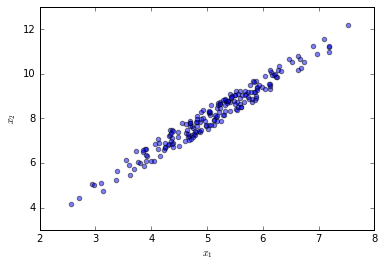

In [35]:
np.random.seed(1)
x0 = np.random.randn(200) + 5.0
x1 = 1.5*x0 + np.random.rand(len(x0))

ax = plt.axes()
ax.scatter(x0, x1, alpha=0.5);
ax.set_xlabel('$x_{1}$');
ax.set_ylabel('$x_{2}$');

We collect the data in a $200 \times 2$ matrix $\boldsymbol{X}$ (200 measurements, 2 variables):

In [36]:
X = np.column_stack((x0, x1))

We can compute the covariance matrix $\boldsymbol{C}$ by making the columns of $\boldsymbol{X}$ zero mean and computing $\boldsymbol{X}^{T}\boldsymbol{X}^{T}/(N-1)$

In [37]:
for c in range(X.shape[1]):
    X[:,c] = X[:,c] - np.mean(X[:,c])
C = (X.T).dot(X)/(len(x0)-1.0)

The covariance matrix is square and symmetric, so w can diagonalise it by computing the eigenvalues and eigenvectors.

We could also compute the SVD of $\boldsymbol{X}$ since the $\boldsymbol{V}$ is made of the eigenvectors of $\boldsymbol{X}^{T}\boldsymbol{X}^{T}$:

In [38]:
U, s, V = np.linalg.svd(C)
print(s)

[ 2.86471197  0.02380521]


Plotting the data set and the principal directions:

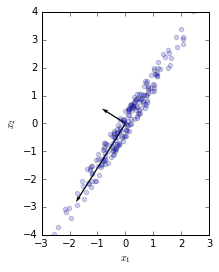

In [39]:
ax = plt.axes()
ax.set_aspect(1.0);
ax.set_ylim(-4.0, 4.0);
ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')
ax.quiver(V[0, 0], V[0, 1], angles='xy',scale_units='xy',scale=0.3);
ax.quiver(V[1, 0], V[1, 1], angles='xy',scale_units='xy',scale=1);
ax.scatter(X[:,0], X[:,1], alpha=0.2);


PCA effectively detects correlation in a data set. In the above example it suggest that the system could be modelled with one variable in the direction of the first column of $\boldsymbol{V}$.